In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import requests
from pprint import pprint
pd.options.display.float_format = '{:,.2f}'.format

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

EPA_state_summary = []

# State Abbreviations
states = ["AL", "AR", "CA", "CO", "DC", "DE", "FL", "HI", "ID",
          "IL", "IN", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MS", "MO",
          "MT", "NE", "NV", "NH", "NJ", "NM", "NC", "ND", "OH", "OK", "OR", "PA",
          "SC", "SD", "TN", "TX", "UT", "VT", "WA", "WV", "WI", "WY"]

for state in states:

    # File to Load
    EPADataFile = "../1_Input/EPA/water_system_summary_" + state + ".csv"
    
    # Load to dataframe
    EPA_State_data = pd.read_csv(EPADataFile)
    
    # Drop columns to minimize resource usage
    EPA_State_data = EPA_State_data.drop(columns = ['PWS Name', 'PWS Type', 'Primary Source', 'Counties Served',
                                 'Cities Served', 'Number of Facilities', 'Number of Site Visits'])
    
    
    # Get specific variables
    totalWaterSystems = len(EPA_State_data)
    populationServed = EPA_State_data["PopulationServed Count"].sum()
    totalViolations = EPA_State_data["Number of Violations"].sum()
    
    EPA_state_summary.append([state, totalWaterSystems, populationServed, totalViolations])

# Create Summary Data Frame
EPA_Violations_df = pd.DataFrame(EPA_state_summary, columns=['State',
                                                    'Number of Water Systems',
                                                    'Population Served',
                                                    'Number of Violations'])

EPA_Violations_df.head()

,State,Number of Water Systems,Population Served,Number of Violations
0,AL,581,5683911,8723
1,AR,1054,2888839,13990
2,CA,7499,42679064,70484
3,CO,2013,6133087,51549
4,DC,6,665602,78


In [2]:
# Create Summary Data Frame
EPA_WViolations_df = pd.DataFrame(EPA_Violations_df, columns=['State',
                                                    'Number of Violations'])

EPA_WViolations_df.head()

,State,Number of Violations
0,AL,8723
1,AR,13990
2,CA,70484
3,CO,51549
4,DC,78


In [3]:
national_agency_base = "https://api.usa.gov/crime/fbi/sapi/api/participation/national?api_key={myapi_key}"
violent_state_base = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/violent-crime/offense/states/"
api_key_url = "/count?api_key="
myapi_key = "FaiahkB1PpyTF7e8qEp6JZ3TnOmokQ2sW2OTU099"

state_list = []
year_list = []
offense_name_list = []
offense_count_list = []

for state in states:
    violent_state_url = violent_state_base + state + api_key_url + myapi_key 
    response = requests.get(violent_state_url).json()

    if int(response['pagination']['count'])!=0:
        for i in range(len(response['results'])):
            #print()
            if response['results'][i]['data_year'] in range(1999,2017): 
                state_list.append(state)
                year_list.append(response['results'][i]['data_year'])
                offense_name_list.append(response['results'][i]['offense_name'])
                offense_count_list.append(response['results'][i]['offense_count'])
        #print(state)
        #pprint(response)

In [4]:
FBI_data_all = pd.DataFrame({'State': state_list,
                         'Year': year_list,
                         'Offense': offense_name_list,
                         'Offense Count': offense_count_list
                        })
FBI_data_all.head()

,State,Year,Offense,Offense Count
0,AL,2006,aggravated-assault,31
1,AL,2007,aggravated-assault,33
2,AL,2008,aggravated-assault,34
3,AL,2009,aggravated-assault,33
4,AL,2010,aggravated-assault,24


In [5]:
#FBI2016_df = FBI_data_all.reset_index()
FBI2016_df = FBI_data_all.loc[FBI_data_all['Year']==2016]
FBI2016_df.head()

,State,Year,Offense,Offense Count
10,AL,2016,aggravated-assault,44
19,AL,2016,homicide,3
30,AL,2016,rape,19
41,AL,2016,robbery,56
58,AR,2016,aggravated-assault,11672


In [6]:
index = FBI2016_df.groupby(["State"])
#OR if you want Year in there -- index = FBI2016_df.groupby(["State", "Year"])
offcount = FBI2016_df.groupby("Year")["Offense Count"].sum()
FBI_data_2016 = pd.DataFrame(index["Offense Count"].sum())
FBI_data_2016.head()

,Offense Count
State,
AL,122
AR,16953
CO,20327
DC,547
DE,5110


In [7]:
#Merge both datasets
FBIUSWATER2016 = pd.merge(EPA_WViolations_df, FBI_data_2016, on='State', suffixes=['_EPA', '_FBI'])
fbiwater_df = FBIUSWATER2016.rename(index=str, columns={"Number of Violations": "Water Violations", "Offense Count": "Total Violent Offenses"})
fbiwater_df2 = fbiwater_df.set_index('State')
fbiwater_df2.head()

,Water Violations,Total Violent Offenses
State,,
AL,8723,122
AR,13990,16953
CO,51549,20327
DC,78,547
DE,3129,5110


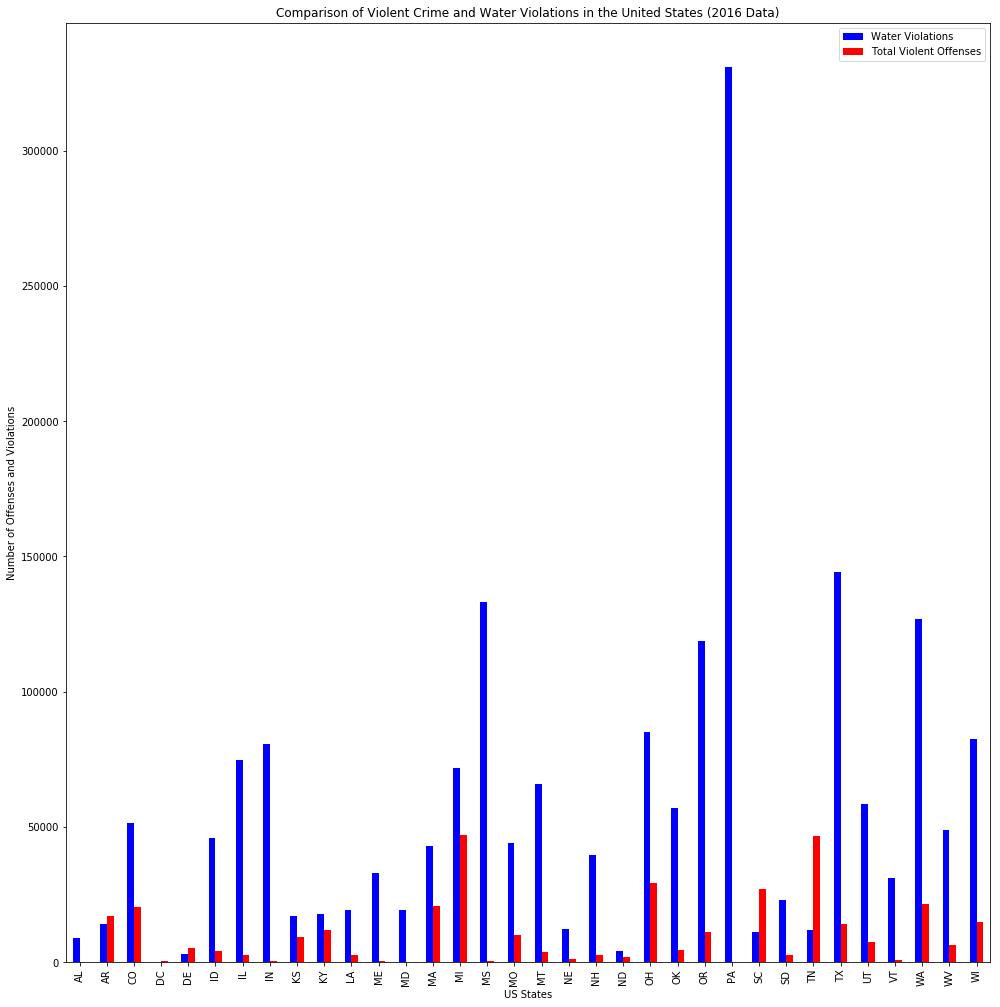

In [8]:
# Build the plots for each city 
first_graph = fbiwater_df2.plot.bar(rot=0, color = ['b', 'r'], legend=True,)

# Incorporate the other graph properties
plt.xlabel("US States")
plt.ylabel("Number of Offenses and Violations")
plt.title("Comparison of Violent Crime and Water Violations in the United States (2016 Data)")

plt.gcf().set_size_inches(14, 14)
plt.tight_layout()
plt.xticks(rotation=90)
# Save Figure
plt.savefig('../6_Output/Bar Graph Comparison of Violent Crime and Water Violations in the United States (2016 Data)', bbox_inches="tight")

# Show Figure
plt.show()